## Lab 7: Eel Distribution Modeling with XGBoost

**Reference Paper:** [Elith et al. (2008)](https://ucsb.box.com/s/6k7636wsbogdg3orarxrlowke0ounbic)

In this lab, you will model the distribution of the eel species *Anguilla australis* using **boosted classification trees (BCTs)**, a machine learning technique that improves predictive performance by combining multiple decision trees. Elith et al. (2008) offered an early implementation of BRTs in an ecological setting to understand how environmental variables influence eel distribution.

You will work with **two datasets**:
1. **Training Data** – Used to build and evaluate your XGBoost model.
2. **Evaluation Data** – Used to assess model performance on unseen data.

To achieve the following objectives:
- Train and fine-tune an **XGBoost** model for classification of species presence/absence data.
- Compare your model’s performance to the approach used by Elith et al.


**Wherever applicable in this lab, use a random state of 808.**

### Step 0: Load libraries and data


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import uniform, randint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Download the datasets
model_data = pd.read_csv("data/model.data.csv").drop(columns=['Site'])
eval_data = pd.read_csv("data/eval.data.csv")

# View model data dtypes
print(model_data.dtypes)
print(eval_data.dtypes)

# View uniques in method column
print(model_data['Method'].unique())
print(eval_data['Method'].unique())

Angaus          int64
SegSumT       float64
SegTSeas      float64
SegLowFlow    float64
DSDist        float64
DSMaxSlope    float64
USAvgT        float64
USRainDays    float64
USSlope       float64
USNative      float64
DSDam           int64
Method         object
LocSed        float64
dtype: object
Angaus_obs      int64
SegSumT       float64
SegTSeas      float64
SegLowFlow    float64
DSDist        float64
DSMaxSlope    float64
USAvgT        float64
USRainDays    float64
USSlope       float64
USNative      float64
DSDam           int64
Method         object
LocSed        float64
dtype: object
['electric' 'spo' 'trap' 'mixture' 'net']
['electric' 'net' 'mixture' 'spo' 'trap']


In [26]:
eval_data

,Angaus_obs,SegSumT,SegTSeas,SegLowFlow,DSDist,DSMaxSlope,USAvgT,USRainDays,USSlope,USNative,DSDam,Method,LocSed
0,0,16.6,1.01,1.017,5.230,0.29,-1.40,1.980,10.0,1.00,0,electric,4.9
1,1,16.8,-0.51,1.002,2.240,0.00,0.27,0.460,0.7,0.00,0,electric,2.3
2,0,16.3,0.76,1.023,162.280,5.14,-0.60,0.806,21.4,0.66,0,electric,4.3
3,0,15.6,1.56,1.003,4.050,0.57,1.14,3.300,0.9,0.75,0,net,1.0
4,0,14.6,-0.20,1.023,127.030,1.72,-1.90,1.940,28.9,0.97,0,electric,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,18.2,0.39,1.024,171.550,0.57,-0.20,1.277,9.6,0.10,0,electric,3.6
496,0,18.6,1.43,1.001,0.807,0.57,0.25,1.513,10.0,0.00,0,trap,NaN
497,0,16.8,-3.71,1.063,171.620,1.72,-6.00,0.210,10.1,0.83,1,electric,NaN
498,0,16.6,-0.69,1.055,67.980,1.72,-0.90,1.220,15.1,0.47,0,electric,4.8


### Step 1:Initial Data Preprocessing
Let's get started by preparing our data. `Angaus` will be our target variable(`y`), and all other variables will be our features (`X`). Then encode the categorical feature using `LabelEncoder()`. The final step will be a bit different this time.  We don't need to split off testing data for the final model evaluation; a separate set (`eval_data`) will be used as in Elith et al.  We do, however, need to split our data in order to do the early stopping process. When splitting your data into training and validation, use a test size of 0.2 and a random state of 808. 

In [27]:
# Encode Method column to numeric in model data
label_encoder = LabelEncoder()
model_data['Method'] = label_encoder.fit_transform(model_data['Method'])

# Encode Method column to numeric in eval data 
eval_data['Method'] = label_encoder.fit_transform(eval_data['Method'])

# Should be 5 outputs just like original
print(model_data['Method'].unique())
print(eval_data['Method'].unique())

[0 3 4 1 2]
[0 2 1 3 4]


In [28]:
eval_data

,Angaus_obs,SegSumT,SegTSeas,SegLowFlow,DSDist,DSMaxSlope,USAvgT,USRainDays,USSlope,USNative,DSDam,Method,LocSed
0,0,16.6,1.01,1.017,5.230,0.29,-1.40,1.980,10.0,1.00,0,0,4.9
1,1,16.8,-0.51,1.002,2.240,0.00,0.27,0.460,0.7,0.00,0,0,2.3
2,0,16.3,0.76,1.023,162.280,5.14,-0.60,0.806,21.4,0.66,0,0,4.3
3,0,15.6,1.56,1.003,4.050,0.57,1.14,3.300,0.9,0.75,0,2,1.0
4,0,14.6,-0.20,1.023,127.030,1.72,-1.90,1.940,28.9,0.97,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,18.2,0.39,1.024,171.550,0.57,-0.20,1.277,9.6,0.10,0,0,3.6
496,0,18.6,1.43,1.001,0.807,0.57,0.25,1.513,10.0,0.00,0,4,NaN
497,0,16.8,-3.71,1.063,171.620,1.72,-6.00,0.210,10.1,0.83,1,0,NaN
498,0,16.6,-0.69,1.055,67.980,1.72,-0.90,1.220,15.1,0.47,0,0,4.8


In [29]:
# Define the target and features
X = model_data.drop(columns=['Angaus'])
y = model_data['Angaus']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=808)


### Step 2: Determine best number of trees using early stopping
As a guard against overfitting while maximizing performance, we use **early stopping**. We start with a large number of trees and allow XGBoost to determine the optimal number by stopping training when the validation error no longer improves.

The choice of hyperparameter starting values is important in this process. We begin with:
- `n_estimators=1000` to ensure the model has enough capacity to learn meaningful patterns.
- `learning_rate=0.1` as a reasonable default that balances learning speed and performance.
- `eval_metric="logloss"` as the metric of performance to optimize.
- `early_stopping_rounds=50` to halt training if no improvement is seen for 50 rounds, preventing unnecessary computations.
- `random_state = 808`

We then `fit()` our specified baseline model, passing in the training sets as usual and specifying validation sets values for the `eval_set` parameter.

Finally, get and print the best number of trees from the fitted baseline model.


In [30]:
# Train a XGBoost model
model = XGBClassifier(
    n_estimators = 1000,
    learning_rate = 0.1,
    eval_metric = 'logloss',
    early_stopping_rounds = 50,
    random_state = 808)

# Fit the model and specify validation sets
model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Best number of trees from baseline model
best_ntree = model.best_iteration
print(f"The best number of trees is: {best_ntree}")


[0]	validation_0-logloss:0.51354
[1]	validation_0-logloss:0.48803
[2]	validation_0-logloss:0.46738
[3]	validation_0-logloss:0.45126
[4]	validation_0-logloss:0.43766
[5]	validation_0-logloss:0.42555
[6]	validation_0-logloss:0.41728
[7]	validation_0-logloss:0.40769
[8]	validation_0-logloss:0.40082
[9]	validation_0-logloss:0.39562
[10]	validation_0-logloss:0.39263
[11]	validation_0-logloss:0.38984
[12]	validation_0-logloss:0.38489
[13]	validation_0-logloss:0.38327
[14]	validation_0-logloss:0.37803
[15]	validation_0-logloss:0.37652
[16]	validation_0-logloss:0.37337
[17]	validation_0-logloss:0.37156
[18]	validation_0-logloss:0.36987
[19]	validation_0-logloss:0.36868
[20]	validation_0-logloss:0.36809
[21]	validation_0-logloss:0.36721
[22]	validation_0-logloss:0.36763
[23]	validation_0-logloss:0.36570
[24]	validation_0-logloss:0.36577
[25]	validation_0-logloss:0.36666
[26]	validation_0-logloss:0.36559
[27]	validation_0-logloss:0.36552
[28]	validation_0-logloss:0.36422
[29]	validation_0-loglos

### Step 3: Tune Learning Rate

The (`learning_rate` hyperparameter controls how much each tree contributes to improving the model's performance. A *higher* learning rate allows the model to learn quickly but risks missing the optimal solution and overfitting, while a *lower* learning rate makes learning slower but can improve generalization.

To find the optimal value, we'll use **randomized search cross-validation** (`RandomizedSearchCV`) to test different learning rates in the 0.01 to 0.3 range. Instead of testing every possible value, this method samples a set number of candidates (`n_iter`) from a defined parameter distribution.  In this case, sampling 20 candidates from a uniform distribution between `0.01` and `0.31`. Check out the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html) on `scipy.stats.uniform` to see how it differs from `random.uniform`. Be sure to use a random state of 808.

After using `RandomizedSearchCV`, fit your model. Print the best learning rate. 


In [31]:
# Define hyperparameter distributions
param_distributions = {
    'learning_rate': uniform(0.01, 0.3),
}

# Set up RandmoizedSearchCV
random_search = RandomizedSearchCV(
    model, param_distributions, 
    n_iter = 20, 
    cv = 5, 
    verbose=1, 
    random_state = 808
)

random_search.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Print best learning rate
best_rate = random_search.best_params_['learning_rate']
print(f"The best learning rate is: {best_rate}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[0]	validation_0-logloss:0.47868
[1]	validation_0-logloss:0.44759
[2]	validation_0-logloss:0.42944
[3]	validation_0-logloss:0.41678
[4]	validation_0-logloss:0.40773
[5]	validation_0-logloss:0.40041
[6]	validation_0-logloss:0.40033
[7]	validation_0-logloss:0.39620
[8]	validation_0-logloss:0.39157
[9]	validation_0-logloss:0.38942
[10]	validation_0-logloss:0.38766
[11]	validation_0-logloss:0.37911
[12]	validation_0-logloss:0.37980
[13]	validation_0-logloss:0.38650
[14]	validation_0-logloss:0.38707
[15]	validation_0-logloss:0.38919
[16]	validation_0-logloss:0.39080
[17]	validation_0-logloss:0.39211
[18]	validation_0-logloss:0.38907
[19]	validation_0-logloss:0.39917
[20]	validation_0-logloss:0.40104
[21]	validation_0-logloss:0.39480
[22]	validation_0-logloss:0.39685
[23]	validation_0-logloss:0.40166
[24]	validation_0-logloss:0.40769
[25]	validation_0-logloss:0.40680
[26]	validation_0-logloss:0.41257
[27]	validation_0-logloss:0.40

### Step 4: Tune Tree-Specific Parameters

Now that we've determined the best number of tree and learning rate, we need to tune the complexity of individual trees in our model. Initialize your model with the best number of trees and learning rate.Then, define a parameter dictionary that takes on the following values:  

- `max_depth`(Controls how deep each tree can grow.  Takes integer values): A random integer from 3 to 10 ( inclusive of 3 and 10)
- `min_child_weight`( Determines the minimum number of samples required in a leaf node. Takes integer values) : A random integer from 1 to 10 ( inclusive of 1 and 10)
- `gamma` (Defines the minimum loss reduction needed to make a further split in a tree. Can take on values from a continuous range):  A uniform distribution from 0.05 to 0.10 - once again remember to check the `scipy.stats.uniform()` documentation! 
- `random_state = 808`

To find the best combination, we again use `RandomizedSearchCV`, allowing us to efficiently sample hyperparameters and evaluate different configurations using cross-validation. After fitting the model, print the best parameters. 



In [32]:
# Train a new  model with the best hyperparameters
model = XGBClassifier(
    n_estimators = best_ntree,
    learning_rate = best_rate,
    eval_metric = 'logloss',
    early_stopping_rounds = 50,
    random_state = 808
)

# Define new parameter distribution
param_dist = {
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0.05, 0.05)
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    model, param_dist, 
    n_iter = 10, 
    cv = 5, 
    verbose=1, 
    random_state = 808
)

# Fit the model
random_search.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Print best parameters
best_tree_params = random_search.best_params_
print(f"The best parameters are: {best_tree_params}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0]	validation_0-logloss:0.48196
[1]	validation_0-logloss:0.45344
[2]	validation_0-logloss:0.43002
[3]	validation_0-logloss:0.41237
[4]	validation_0-logloss:0.40310
[5]	validation_0-logloss:0.39034
[6]	validation_0-logloss:0.38197
[7]	validation_0-logloss:0.37925
[8]	validation_0-logloss:0.37046
[9]	validation_0-logloss:0.36796
[10]	validation_0-logloss:0.36369
[11]	validation_0-logloss:0.36338
[12]	validation_0-logloss:0.36140
[13]	validation_0-logloss:0.36123
[14]	validation_0-logloss:0.36291
[15]	validation_0-logloss:0.36378
[16]	validation_0-logloss:0.36888
[17]	validation_0-logloss:0.36792
[18]	validation_0-logloss:0.36938
[19]	validation_0-logloss:0.36511
[20]	validation_0-logloss:0.36455
[21]	validation_0-logloss:0.36241
[22]	validation_0-logloss:0.35815
[23]	validation_0-logloss:0.35639
[24]	validation_0-logloss:0.35897
[25]	validation_0-logloss:0.36338
[26]	validation_0-logloss:0.36167
[27]	validation_0-logloss:0.360

### Step 5: Tune Stochastic Components

Now, we are finally ready to tune the stochastic components of the XGBoost model.  These parameters help prevent overfitting by reducing correlation between trees. Initialize your model with the best number of trees, best learning rate,and your optimized tree values (**Note**: you can use \**best_tree_parameters to unpack the the dictionary of optimzed tree values) .Then, define a parameter dictionary that takes on the following values:  

- `subsample` (Controls the fraction of training samples used for each boosting round) : A uniform distribution between .5 and .10 (remeber to check `scipy.stats.uniform()` documentation! )
- `colsample_bytree`(Specifies the fraction of features to consider when building each tree) : A uniform distribution between .5 and .10
- `random_state = 808`

We again use `RandomizedSearchCV` to find the best combination of these parameters. After fitting the model, print the best parameters. 


In [33]:
# Define paramater distribution
param_dist = {
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5)
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    model, param_dist, 
    n_iter = 10, 
    cv = 5, 
    verbose=1, 
    random_state = 808
)

# Fit the model
random_search.fit(X_train, y_train, eval_set=[(X_test, y_test )])

# Print best parameters
best_stochastic_params = random_search.best_params_
print(f"The best parameters are: {best_stochastic_params}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0]	validation_0-logloss:0.49783
[1]	validation_0-logloss:0.47703
[2]	validation_0-logloss:0.46535
[3]	validation_0-logloss:0.43943
[4]	validation_0-logloss:0.42332
[5]	validation_0-logloss:0.41810
[6]	validation_0-logloss:0.40510
[7]	validation_0-logloss:0.40060
[8]	validation_0-logloss:0.39975
[9]	validation_0-logloss:0.39496
[10]	validation_0-logloss:0.38602
[11]	validation_0-logloss:0.38888
[12]	validation_0-logloss:0.39671
[13]	validation_0-logloss:0.39856
[14]	validation_0-logloss:0.40316
[15]	validation_0-logloss:0.39934
[16]	validation_0-logloss:0.39801
[17]	validation_0-logloss:0.40598
[18]	validation_0-logloss:0.41475
[19]	validation_0-logloss:0.42261
[20]	validation_0-logloss:0.41865
[21]	validation_0-logloss:0.42642
[22]	validation_0-logloss:0.42826
[23]	validation_0-logloss:0.43066
[24]	validation_0-logloss:0.43304
[25]	validation_0-logloss:0.43403
[26]	validation_0-logloss:0.44326
[27]	validation_0-logloss:0.443

### Step 6: Final Model Training and Evaluation

With the best hyperparameters selected, we now train the final model on the full training dataset and evaluate it on the separate evaluation dataset.

1. Prepare the evaluation data in the same manner as you did the training data

2. Train final model using the best parameters found in previous tuning steps (`best_tree_params`, `best_stochastic_params`).Set  `eval_metric = "logloss"` 

3. Fit the model to the full training dataset and predict on the evaluation data 


In [34]:
# Define eval data
X_eval = eval_data.drop(columns=['Angaus_obs'])
y_eval = eval_data['Angaus_obs']

# Train a new model with the best hyperparameters
model = XGBClassifier(
    n_estimators = best_ntree,
    learning_rate = best_rate,
    max_depth = best_tree_params['max_depth'],
    min_child_weight = best_tree_params['min_child_weight'],
    gamma = best_tree_params['gamma'],
    subsample = best_stochastic_params['subsample'],
    colsample_bytree = best_stochastic_params['colsample_bytree'],
    eval_metric = 'logloss',
    early_stopping_rounds = 50,
    random_state = 808
)

# Fit the model
model.fit(X, y, eval_set=[(X_eval, y_eval)])

# Predict on eval data
y_pred = model.predict_proba(X_eval)[:,1]

[0]	validation_0-logloss:0.47309
[1]	validation_0-logloss:0.44544
[2]	validation_0-logloss:0.42556
[3]	validation_0-logloss:0.40573
[4]	validation_0-logloss:0.39190
[5]	validation_0-logloss:0.38266
[6]	validation_0-logloss:0.37565
[7]	validation_0-logloss:0.36891
[8]	validation_0-logloss:0.36906
[9]	validation_0-logloss:0.36120
[10]	validation_0-logloss:0.35820
[11]	validation_0-logloss:0.35536
[12]	validation_0-logloss:0.35450
[13]	validation_0-logloss:0.35392
[14]	validation_0-logloss:0.35348
[15]	validation_0-logloss:0.35598
[16]	validation_0-logloss:0.35684
[17]	validation_0-logloss:0.35725
[18]	validation_0-logloss:0.35651
[19]	validation_0-logloss:0.35908
[20]	validation_0-logloss:0.36122
[21]	validation_0-logloss:0.35911
[22]	validation_0-logloss:0.35990
[23]	validation_0-logloss:0.36093
[24]	validation_0-logloss:0.35897
[25]	validation_0-logloss:0.36004
[26]	validation_0-logloss:0.36113
[27]	validation_0-logloss:0.36248
[28]	validation_0-logloss:0.36139


### Step 7: Model Performance

Compute and print the AUC and feature importances for your model.

In [35]:
# Compute training AUC
train_preds = model.predict_proba(X)[:,1]
train_auc = roc_auc_score(y, train_preds)
print(f"Training AUC: {train_auc}")

Training AUC: 0.9533642274001836


In [36]:
# Compute evaluation AUC
auc = roc_auc_score(y_eval, y_pred)
print(f"AUC Value: {auc:.3f}")

AUC Value: 0.874


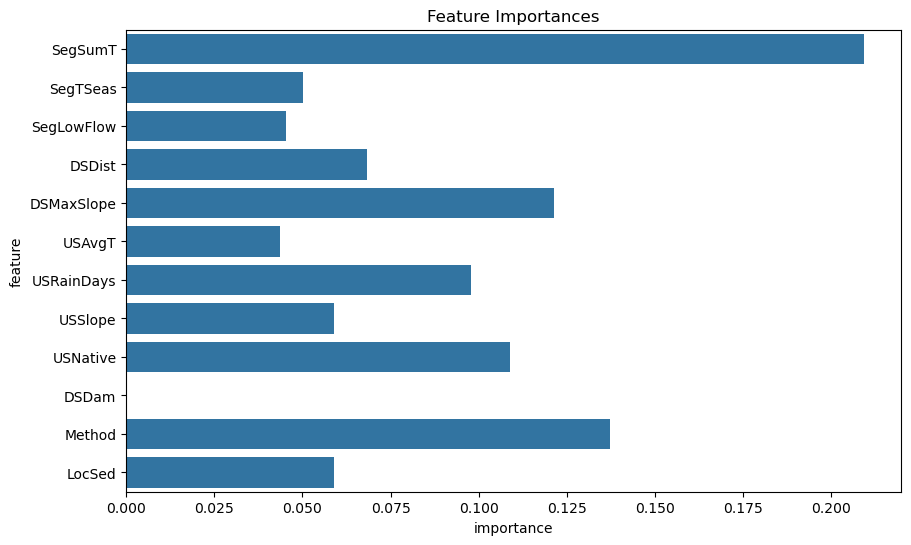

In [37]:
# Calculate the feature importances
importances = model.feature_importances_
importances_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
})

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=importances_df, x='importance', y='feature')
plt.title('Feature Importances')
plt.show()

### Step 8: The comparison
How does your model's performance compare to the of Elith et al. (See Tables 2 and 3)?  Is there another way to compare the models in addition to predictive performance?  Whose model wins in that regard?

The model has a similar value to the ones run in the paper. The cross validation model by Elith et al. has an AUC value of 0.869 while we have an AUC of 0.874. Another way that might be good to compare models would to make a confusion matrix for both. It would interesting to compare the Type I and II errors to one another. 